# Stock Information

In [40]:
import yfinance as yf
import pandas as pd
import os
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import time

# Set the number of cores to use
NUM_CORES = multiprocessing.cpu_count() 
# Load stock info
stock_info = pd.read_csv('src/stock_info.csv')

def mkdir(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def get_stock_data(ticker, period='5d'):
    try:  
        time.sleep(0.1)
        data = yf.download(ticker, period=period, interval='1d')  
        if 'Date' not in data.columns:
            data['Date'] = data.index
        return ticker, data  
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return ticker, None

def calculate_price_change(data):
    if len(data) < 2:
        return None
    current_price = data['Close'].iloc[-1]
    previous_close = data['Close'].iloc[-2]
    price_change = (current_price - previous_close) / previous_close * 100
    return round(price_change, 3)

def calculate_rsi(data, period=14):
    delta = data['Close'].diff(1)
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    avg_gain = up.ewm(com=period-1, adjust=False).mean()
    avg_loss = down.ewm(com=period-1, adjust=False).mean().abs()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.iloc[-1]

def calculate_macd(data):  
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd.iloc[-1], signal.iloc[-1], macd.iloc[-1] - signal.iloc[-1]

def get_company_name(ticker):
    company_name = stock_info[stock_info['Ticker'] == ticker]['Name'].values
    return company_name[0] if len(company_name) > 0 else "Unknown"

def get_ticker_info(ticker):
    info = yf.Ticker(ticker).info
    return info

def process_ticker(ticker, period='5d'):
    ticker, data = get_stock_data(ticker, period)
    if data is None or data.empty:
        return None, ticker, None

    if 'Date' not in data.columns: 
        date_index = data.index[-1] 
        data['Date'] = pd.Series(date_index, index=data.index)

    price_change = calculate_price_change(data) 
    rsi_score = calculate_rsi(data)
    macd, macd_signal, macd_hist = calculate_macd(data)
    
    if price_change is None or rsi_score is None or macd is None:
        return None, ticker, None

    current_date = data['Date'].iloc[-1]   
    previous_price = data['Close'].iloc[-2]
    current_price = data['Close'].iloc[-1]
    open_price = data['Open'].iloc[-1]
    company_name = get_company_name(ticker)
    ticker_info = get_ticker_info(ticker)
    beta = ticker_info.get('beta', None)
    pe_ratio = ticker_info.get('trailingPE', None)
    market_cap = ticker_info.get('marketCap', None)
    sector = ticker_info.get('sector', None)
    fifty_two_week_high = ticker_info.get('fiftyTwoWeekHigh', None)
    fifty_two_week_low = ticker_info.get('fiftyTwoWeekLow', None)
    dividend_yield = ticker_info.get('dividendYield', None)
    avg_volume = ticker_info.get('averageVolume', None)

    result = [company_name, ticker, sector, current_date, current_price, open_price, previous_price, price_change, beta, pe_ratio, market_cap, fifty_two_week_high, fifty_two_week_low, dividend_yield, avg_volume, rsi_score, macd, macd_signal, macd_hist]
    return result, ticker, price_change

def process_chunk(chunk):
    return [process_ticker(ticker) for ticker in chunk]

def evaluate():
    all_tickers = stock_info['Ticker'].to_list()
    chunk_size = max(1, len(all_tickers) // NUM_CORES)
    chunks = [all_tickers[i:i + chunk_size] for i in range(0, len(all_tickers), chunk_size)]
    
    with ProcessPoolExecutor(max_workers=NUM_CORES) as executor:
        results = list(executor.map(process_chunk, chunks))
    
    processed_tickers = []
    
    for chunk_result in results:
        for result, ticker, price_change in chunk_result:
            if ticker and price_change is not None:
                processed_tickers.append(result)
    
    # Save all processed tickers with their metrics
    columns = ["Company", "Ticker", "Sector", "Date", "Current Close", "Open", "Previous Close", "Price Change (%)", "Beta", "P/E Ratio", "Market Cap", "52-Week High", "52-Week Low", "Dividend Yield", "Average Volume", "RSI Score", "MACD", "MACD Signal", "MACD Hist"]    
    processed_df = pd.DataFrame(processed_tickers, columns=columns)

    return processed_df

# Data Analysis

Buy Recommendations:
                          Company Ticker  RSI Score  MACD Hist  \
1702                 Crown Crafts   CRWS   1.960485  -0.015466   
2372    Papa John's International   PZZA   3.704679  -0.235529   
2096             Lcnb Corporation   LCNB   3.799135  -0.047858   
203          Peabody Energy Corp.    BTU   4.733836  -0.045024   
2614                Unity Bancorp   UNTY   4.803153  -0.177793   
1434                   Acnb Corp.   ACNB   5.230335  -0.351656   
1237      Sonoco Products Company    SON   5.455840  -0.167729   
2411           Rgc Resources Inc.   RGCO   5.629233  -0.051291   
308   Cross Timbers Royalty Trust    CRT   5.944171  -0.096477   
2337                   Pool Corp.   POOL   6.128618  -0.632685   

      Price Change (%)   Beta  P/E Ratio  Dividend Yield  
1702             0.513  0.825  10.197917          0.0657  
2372             0.848  1.157  19.392070          0.0422  
2096             1.072  0.752  15.000000          0.0674  
203             

[*********************100%%**********************]  1 of 1 completed


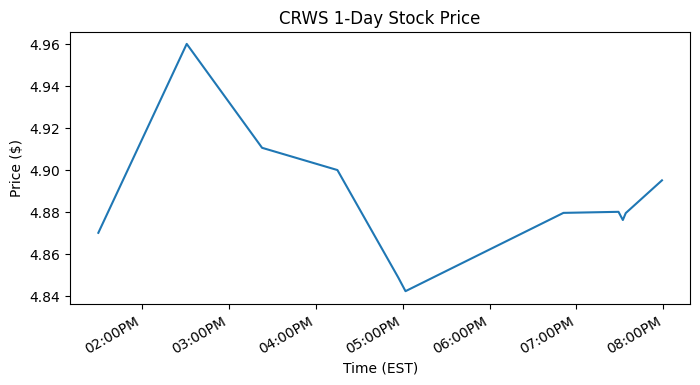

[*********************100%%**********************]  1 of 1 completed


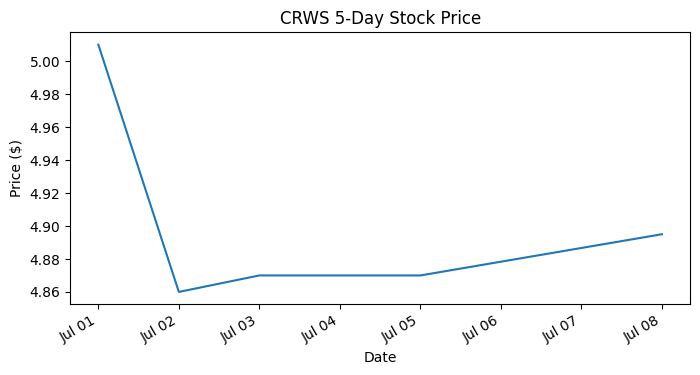

[*********************100%%**********************]  1 of 1 completed


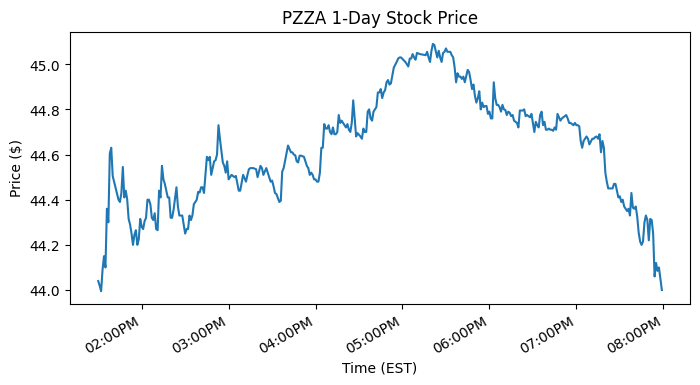

[*********************100%%**********************]  1 of 1 completed


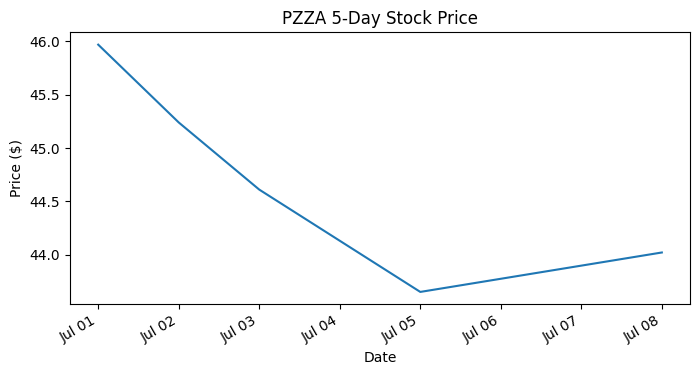

[*********************100%%**********************]  1 of 1 completed


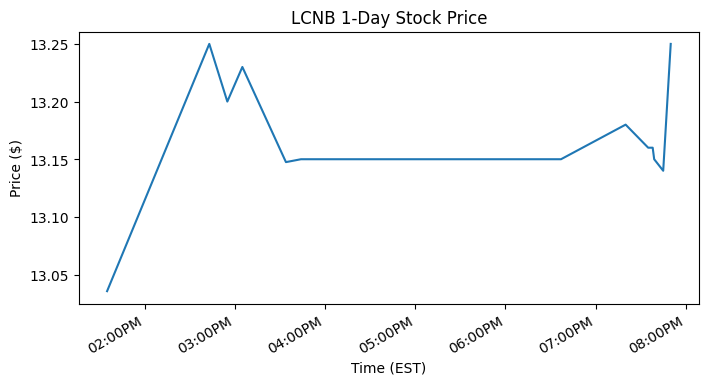

[*********************100%%**********************]  1 of 1 completed


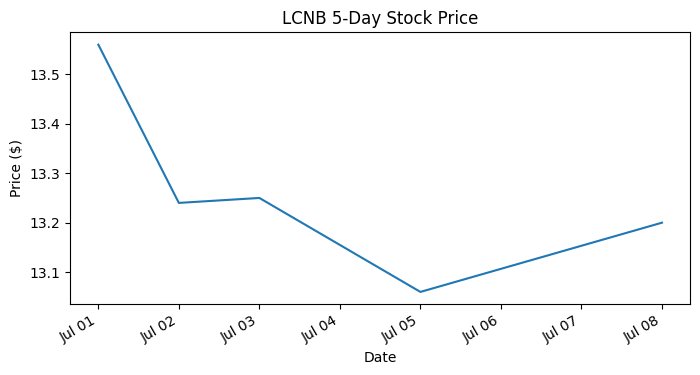

[*********************100%%**********************]  1 of 1 completed


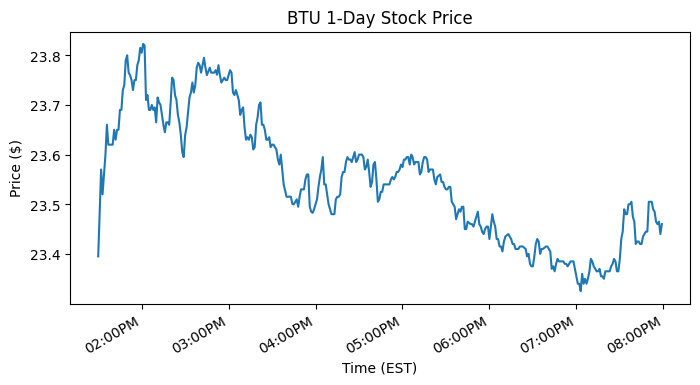

[*********************100%%**********************]  1 of 1 completed


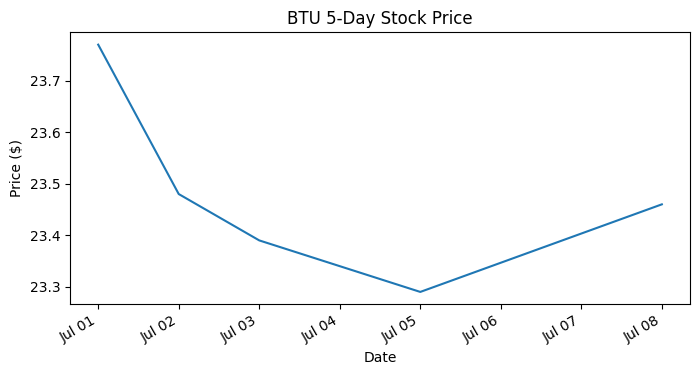

[*********************100%%**********************]  1 of 1 completed


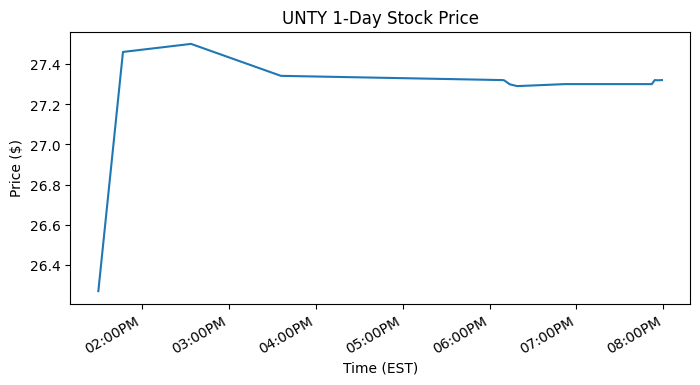

[*********************100%%**********************]  1 of 1 completed


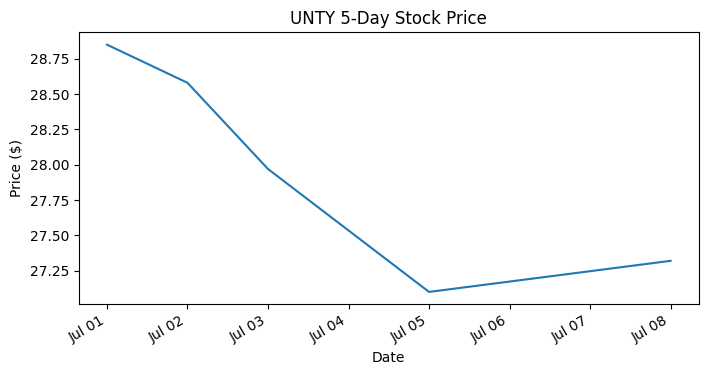

[*********************100%%**********************]  1 of 1 completed


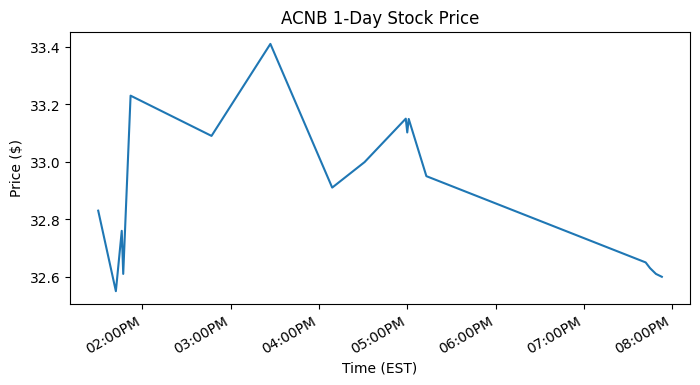

[*********************100%%**********************]  1 of 1 completed


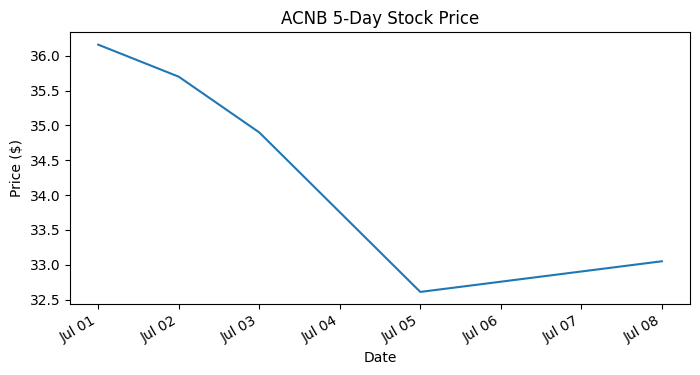

[*********************100%%**********************]  1 of 1 completed


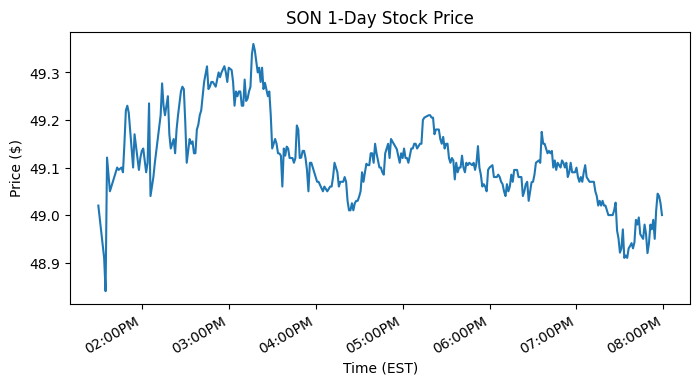

[*********************100%%**********************]  1 of 1 completed


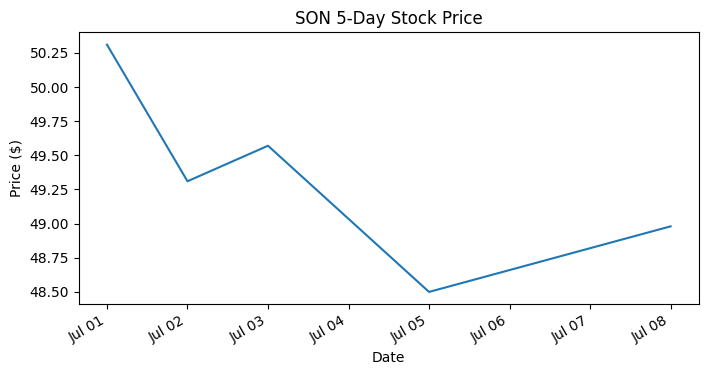

[*********************100%%**********************]  1 of 1 completed


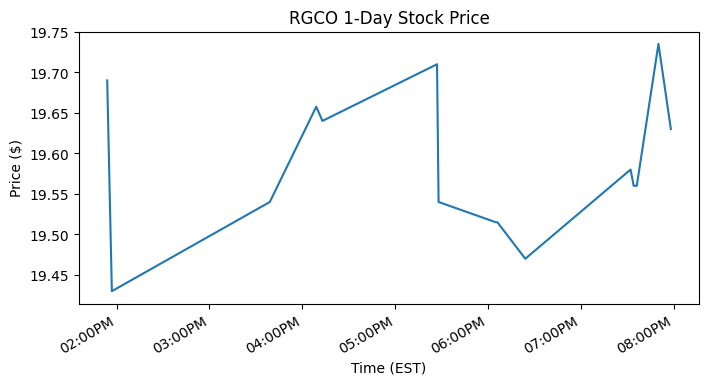

[*********************100%%**********************]  1 of 1 completed


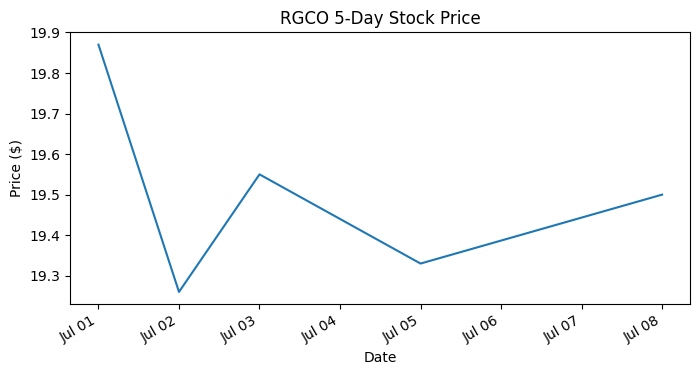

[*********************100%%**********************]  1 of 1 completed


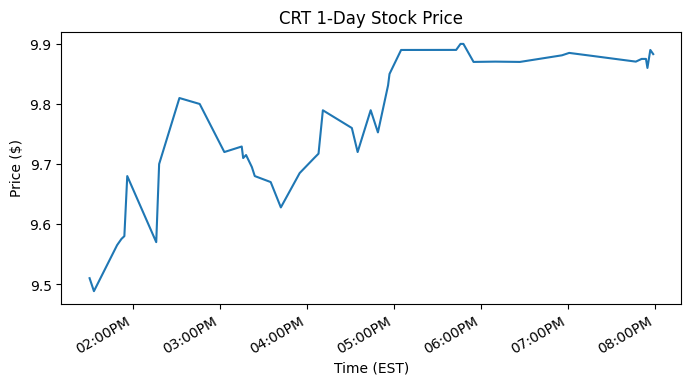

[*********************100%%**********************]  1 of 1 completed


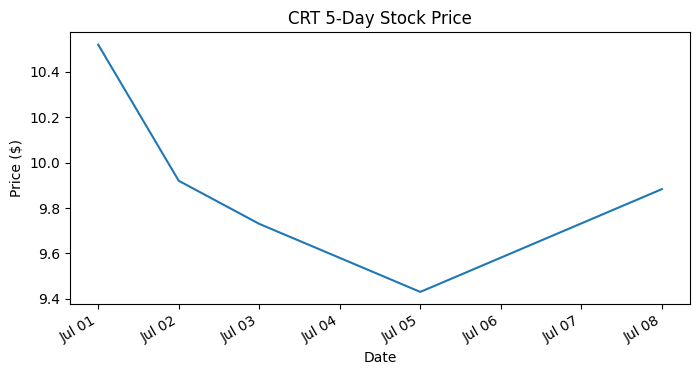

[*********************100%%**********************]  1 of 1 completed


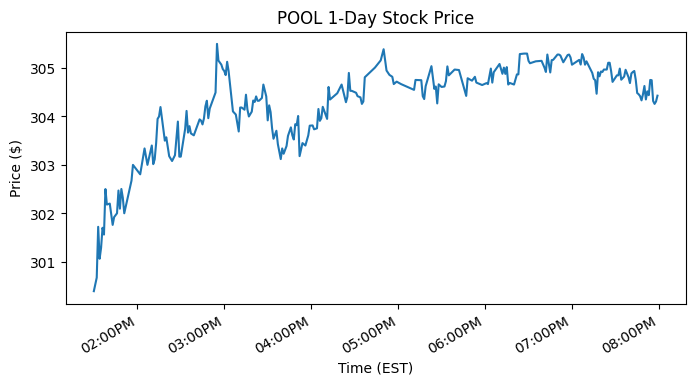

[*********************100%%**********************]  1 of 1 completed


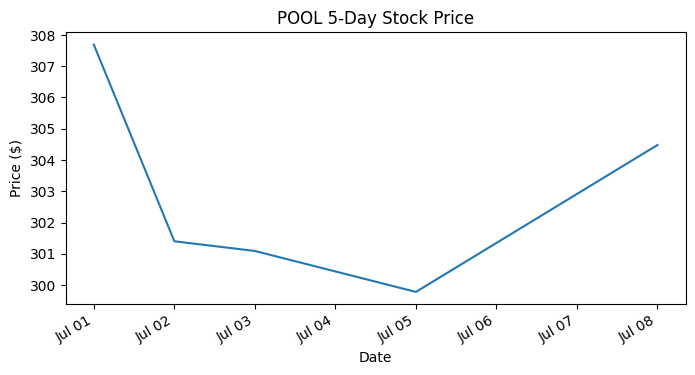

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates

# Create directory structure
today = pd.Timestamp('today').date()
os.makedirs(f'{str(today)}/buy_recommendation', exist_ok=True)


# Load the generated CSV file
output_file = f'{str(today)}/processed_tickers.csv'
df = pd.read_csv(output_file)

# Define the buy criteria
buy_criteria = [
    ('RSI Score', lambda x: x < 40),  # RSI below 40 to include more stocks
    ('MACD Hist', lambda x: x > -1),  # MACD Hist above -1 to be more inclusive 
    ('Price Change (%)', lambda x: x > 0.5),  # Consider any positive price change over 0.5%
    ('Beta', lambda x: x < 2),  # Beta below 2 is still reasonable volatility
    ('P/E Ratio', lambda x: x < 25),  # P/E below 25 to expand the pool
    ('Dividend Yield', lambda x: x > 0)  # Dividend yield positive (eliminate non-dividend payers)
]

# Filter the data based on the buy criteria
buy_stocks = df.copy()
for column, condition in buy_criteria:
    buy_stocks = buy_stocks[buy_stocks[column].apply(condition)]

# Select the top 10 stocks based on the RSI score
buy_stocks = buy_stocks.sort_values('RSI Score').head(10)

# Print the buy recommendations
print("Buy Recommendations:")
print(buy_stocks[['Company', 'Ticker', 'RSI Score', 'MACD Hist', 'Price Change (%)', 'Beta', 'P/E Ratio', 'Dividend Yield']])

# Create graphs to support the buy decisions
for ticker in buy_stocks['Ticker']:
    # Create directory for ticker
    ticker_dir = os.path.join(f'{str(today)}/buy_recommendation', ticker)
    os.makedirs(ticker_dir, exist_ok=True)
    
    # 1-day graph
    stock_data_1d = yf.download(ticker, period='1d', interval='1m')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(stock_data_1d['Close'])
    ax.set_title(f'{ticker} 1-Day Stock Price')
    ax.set_xlabel('Time (EST)')
    ax.set_ylabel('Price ($)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%I:%M%p'))  # Format as 12-hour clock with AM/PM
    fig.autofmt_xdate()
    plt.savefig(os.path.join(ticker_dir, f'{ticker}_1d_stock_price.png'))
    plt.show()
    
    # 5-day graph
    stock_data_5d = yf.download(ticker, period='5d', interval='1d')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(stock_data_5d['Close'])
    ax.set_title(f'{ticker} 5-Day Stock Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    fig.autofmt_xdate()
    plt.savefig(os.path.join(ticker_dir, f'{ticker}_5d_stock_price.png'))
    plt.show()